# Variational Autoencoder
- refers to variational inference
- extension of expectation-maximization
- output of encoder is a guassian, output of decoder is a bernoulli
- then turn output to bayesian --> p(x_reconstructed | x ~ bernoulli(p)) 
- then generate samples from that distribution

#### Parameterize a gaussian
- https://sefiks.com/2017/08/11/softplus-as-a-neural-networks-activation-function/
- approximates p(z|x), the true conditional distribution, as q(z|x)

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
import time
from scipy.stats import multivariate_normal as mvn

In [2]:
def softplus(x):
    # automatically adds 1 
    return np.log1p(np.exp(x))

In [3]:
def forward(x, W1, W2):
    hidden = np.tanh(x.dot(W1))
    output = hidden.dot(W2) # no activation
    mean   = output[:2]
    std    = softplus(output[2:])
    return mean, std

In [4]:
def get_mnist(file,limit=None):
    df = pd.read_csv('datasets/mnist_train_kaggle.csv')
    data = df.values
    # np.random.shuffle(data)
    X = data[:, 1:] / 255.0 # data is from 0..255
    Y = data[:, 0]
    X, Y = shuffle(X, Y)
    if limit is not None:
        X, Y = X[:limit], Y[:limit]
    return X, Y

Make a random input and generate some samples

In [13]:
input_ = 4
hidden = 3
output = 2
W1 = np.random.randn(input_, hidden)
# multiply by 2 for mean and std (2 params!)
W2 = np.random.randn(hidden, output*2)

x = np.random.randn(input_)

mean, std = forward(x, W1, W2)
print("mean: {}, std: {}".format(mean, std))

samples = mvn.rvs(mean=mean, cov=std**2, size=10000)

mean: [ 0.45588209 -1.69395249], std: [0.61537385 0.27954824]


plot the samples

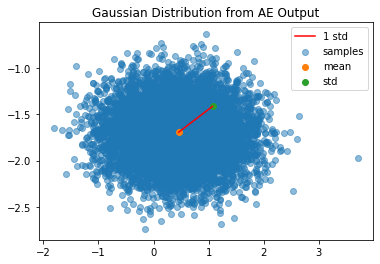

In [16]:
plt.scatter(samples[:,0], samples[:,1], alpha=.5, label='samples')
plt.scatter(mean[0], mean[1], label='mean')
plt.scatter(mean[0]+std[0], mean[1]+std[1], label='std')
plt.plot([mean[0], mean[0]+std[0]], [mean[1], mean[1]+std[1]], 'r', label='1 std')
plt.legend()
plt.title("Gaussian Distribution from AE Output")
plt.show()

#### Variational Inference
Evidence Lower Bound (in variational inference)
- http://users.umiacs.umd.edu/~xyang35/files/understanding-variational-lower.pdf
- https://www.cs.princeton.edu/courses/archive/fall11/cos597C/lectures/variational-inference-i.pdf
- https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence
- E[log p(x|z)] - KLD[q(z|x)||p(z)]
- expected log-likelihood minus KL divergence of posterior and prior (higher KLD -> higher difference)
- ELL tells us how close we are to the target, KLD is regularization penalty

### The Variational Autoencoder

In [19]:
class VariationalAutoencoder:
    def __init__(self, D, H):
        """
            Descr: initializes the encoder
            
            Params:
                D: input layer dimension
                H: hidden layer sizes up to layer Z
        """
        self.X = tf.placeholder(tf.float32, shape=(None, D))
        

In [18]:
normal    = tf.contrib.distributions.Normal
bernoulli = tf.contrib.distributions.Bernoulli